In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

from astropy.io import fits
from astropy.modeling import models, fitting

from photutils.aperture import EllipticalAperture
from photutils.aperture import aperture_photometry

from jwst.residual_fringe.utils import fit_residual_fringes_1d

import os
os.environ['STPSF_PATH'] = '/net/schenk/data2/regt/JWST_reductions/stpsf-data'

In [2]:
from matplotlib.colors import LogNorm, SymLogNorm

In [3]:
class ApertureCorrection:
    def __init__(self, wave, N=50, disperser=None, filter=None, band=None):
    
        import stpsf

        if None not in [disperser, filter]:
            instr = stpsf.NIRSpec()
            instr.mode = 'IFU'
            instr.disperser = disperser
            instr.filter = filter
        elif band is not None:
            instr = stpsf.MIRI()
            instr.mode = 'IFU'
            instr.band = band
        else:
            raise ValueError('Provide either disperser and filter or band')

        self.instr = instr

        # Reduce the wavelength resolution
        self.wave        = wave
        self.wave_binned = np.linspace(wave.min(), wave.max(), N)

        # Calculate the PSF cube upon initialization
        self._get_psf()

    def _get_psf(self):
        
        import astropy.units as u

        # Calculate the PSF cube
        self.psf      = self.instr.calc_datacube(self.wave_binned*1e-6*u.meter)
        self.psf_cube = self.psf['DET_DIST'].data

    def get_correction_factor(self, aper_kwargs):

        # Extract the intensity within the aperture
        xcen, ycen = (self.psf_cube.shape[1]-1)/2, (self.psf_cube.shape[2]-1)/2
        aper_kwargs['positions'] = (xcen, ycen)

        self.flux_binned_in_aper, _ = extract_1d(
            self.wave_binned, self.psf_cube, None, aper_kwargs, plot=False
            )

        # Interpolate to the original wavelength grid
        self.flux_in_aper = np.interp(self.wave, self.wave_binned, self.flux_binned_in_aper)
        self.correction_factor = 1 / self.flux_in_aper

        plt.figure(figsize=(6,3))
        plt.plot(self.wave, self.correction_factor)
        plt.ylim(0,2)
        plt.show()
        return self.correction_factor

        
def load_data(file_s3d, file_x1d):

    wave = fits.getdata(file_x1d)['WAVELENGTH']
    
    hdu = fits.open(file_s3d)
    cube     = hdu['SCI'].data
    cube_err = hdu['ERR'].data

    pixel_area = hdu['SCI'].header['PIXAR_SR']
    cube     *= pixel_area * 1e6 # Convert to flux [MJy/sr] -> [Jy]
    cube_err *= pixel_area * 1e6

    return wave, cube, cube_err

def load_data_Miles_ea_2023(filename):

    wave, flux, flux_err = np.loadtxt(filename).T
    return wave, flux, flux_err
    
def aperture_extraction(image, positions, a, b, theta, image_err=None):

    aperture = EllipticalAperture(positions=positions, a=a, b=b, theta=theta)
    phot_table = aperture_photometry(image, aperture, error=image_err)

    if image_err is None:
        return phot_table['aperture_sum'].data[0], np.nan
    return phot_table['aperture_sum'].data[0], phot_table['aperture_sum_err'].data[0]

def fit_gaussian_2d(cube, xy_guess, inf_coeff=5, plot=False):

    # Median-combine the cube along the wavelength axis
    median_image = np.nanmedian(cube, axis=0)
    median_image -= np.nanmedian(median_image) # Remove the background
    median_image[np.isnan(median_image)] = 0.
    median_image /= np.nanmax(median_image)

    # Fit a 2D Gaussian to the median image
    y, x = np.mgrid[:median_image.shape[0], :median_image.shape[1]]
    fitter = fitting.LevMarLSQFitter()

    # Define the initial guess for the Gaussian parameters
    g_init = models.Gaussian2D(amplitude=1., x_mean=xy_guess[0], y_mean=xy_guess[1], x_stddev=1., y_stddev=1., theta=0.)
    g_init.y_stddev.tied = lambda m: m.x_stddev
    g_init.theta.fixed = True

    # Fit the model to the data
    g_fit = fitter(g_init, x, y, median_image)
    model_image = g_fit(x, y)

    if plot:

        # Plot the results
        median_image = np.nanmedian(cube, axis=0)
        vmax = np.nanpercentile(median_image, 99.5)

        fig, ax = plt.subplots(figsize=(5,5))
        ax.imshow(median_image, vmin=-vmax, vmax=vmax)

        # Plot the fitted Gaussian
        e_kwargs = dict(xy=(g_fit.x_mean.value, g_fit.y_mean.value), angle=g_fit.theta.value*180/np.pi, ec='k', fc='none', lw=0.5, )
        e = [
            Ellipse(width=2*g_fit.x_stddev.value, height=2*g_fit.y_stddev.value, **e_kwargs), 
            Ellipse(width=inf_coeff*2*g_fit.x_stddev.value, height=inf_coeff*2*g_fit.y_stddev.value, **e_kwargs),
        ]
        [ax.add_artist(e_i) for e_i in e]
        plt.show()
    
        '''
        # Plot the results
        fig, ax = plt.subplots(figsize=(10,2.7), ncols=3)
        vmax = np.nanpercentile(median_image, 98)
        ax[0].imshow(median_image, vmin=-vmax, vmax=vmax)
        ax[1].imshow(median_image-model_image , cmap='bwr', vmin=-vmax, vmax=vmax)

        # Plot the fitted Gaussian
        e_kwargs = dict(xy=(g_fit.x_mean.value, g_fit.y_mean.value), angle=g_fit.theta.value*180/np.pi, ec='k', fc='none', lw=0.5, )
        e = [
            Ellipse(width=2*g_fit.x_stddev.value, height=2*g_fit.y_stddev.value, **e_kwargs), 
            Ellipse(width=inf_coeff*2*g_fit.x_stddev.value, height=inf_coeff*2*g_fit.y_stddev.value, **e_kwargs),
        ]
        [ax[0].add_artist(e_i) for e_i in e]

        # Plot the aperture sum as a function of the aperture size
        aper_kwargs = dict(image=median_image, positions=(g_fit.x_mean.value, g_fit.y_mean.value), theta=g_fit.theta.value)
        for sigma_coeff in range(1,10):
            flux, _ = aperture_extraction(a=g_fit.x_stddev.value*sigma_coeff, b=g_fit.y_stddev.value*sigma_coeff, **aper_kwargs)
            ax[2].plot(sigma_coeff, flux, 'o')
        ax[2].axvline(inf_coeff, color='black', ls='--')
        plt.show()
        '''

    return g_fit

def remove_horizontal_stripes(cube, xy_guess=None, inf_coeff=[5,4], plot=False):

    # Median-combine the cube along the wavelength axis
    median_image = np.nanmedian(cube, axis=0)
    median_image -= np.nanmedian(median_image) # Remove the background
    median_image[np.isnan(median_image)] = 0.
    median_image /= np.nanmax(median_image)

    # Determine where the point sources are
    y, x = np.mgrid[:median_image.shape[0], :median_image.shape[1]]
    if xy_guess is None:
        max_idx = np.unravel_index(np.argmax(median_image), median_image.shape)
        min_idx = np.unravel_index(np.argmin(median_image), median_image.shape)
        xy_guess = [(x[max_idx], y[max_idx]), (x[min_idx], y[min_idx])]

    # Fit a 2D Gaussian to the median image
    fitter = fitting.LevMarLSQFitter()

    # Define the initial guess for the Gaussian parameters
    kwargs = dict(x_stddev=1., y_stddev=1., theta=0.)

    for i, xy_guess_i in enumerate(xy_guess):
        amp_i = 1. if i==0 else -1.
        g_i = models.Gaussian2D(amplitude=amp_i, x_mean=xy_guess_i[0], y_mean=xy_guess_i[1], **kwargs)
        
        # Set the bounds for the Gaussian parameters
        g_i.x_stddev.bounds = (1, 20); g_i.y_stddev.bounds = (1, 20)
        g_i.y_stddev.tied = lambda m: m[i].x_stddev
        g_i.theta.fixed = True

        if i==0:
            g_i.amplitude.bounds = (0.5, 1.5)
            g_init = g_i
        else:
            g_i.amplitude.bounds = (-1.5, -0.5)
            g_init += g_i

    # Fit the model to the data
    g_fit = fitter(g_init, x, y, median_image)
    model_image = g_fit(x, y)

    # Mask the point sources
    mask = np.zeros_like(median_image)
    for i, g_i in enumerate(g_fit):
        aperture_i = EllipticalAperture(
            positions=(g_i.x_mean.value, g_i.y_mean.value), theta=g_i.theta.value, 
            a=g_i.x_stddev.value*inf_coeff[i], b=g_i.y_stddev.value*inf_coeff[i]
            )
        mask += aperture_i.to_mask().to_image(median_image.shape)

    mask = (mask!=0.)

    masked_cube = np.copy(cube)
    masked_cube[:,mask] = np.nan

    # Remove the horizontal stripes
    collapse_horizontal = np.nanmedian(masked_cube, axis=2, keepdims=True)
    # from scipy.ndimage import median_filter
    # collapse_horizontal = median_filter(collapse_horizontal, size=(10, 1, 1))

    cube_corrected = cube - collapse_horizontal
    median_image_corrected = np.nanmedian(cube_corrected, axis=0)
    
    masked_cube_corrected = np.copy(cube_corrected)
    masked_cube_corrected[:,mask] = np.nan
    masked_median_image_corrected = np.nanmedian(masked_cube_corrected, axis=0)

    if plot:
        # Plot the results
        median_image = np.nanmedian(cube, axis=0)
        vmax = np.nanpercentile(median_image, 98)

        fig, ax = plt.subplots(figsize=(7,2.7), ncols=2)
        ax[0].imshow(median_image, vmin=-vmax, vmax=vmax, cmap='bwr')
        ax[1].imshow(median_image_corrected, vmin=-vmax, vmax=vmax, cmap='bwr')

        for ax_i in ax:
            e_kwargs = dict(ec='k', fc='none', lw=0.8, )
            e = [
                Ellipse(
                    xy=(g_i.x_mean.value, g_i.y_mean.value), angle=g_i.theta.value*180/np.pi, 
                    width=2*g_i.x_stddev.value*inf_coeff[i], height=2*g_i.y_stddev.value*inf_coeff[i], **e_kwargs
                    )
                for i, g_i in enumerate(g_fit)
            ]
            [ax_i.add_artist(e_i) for e_i in e]
        plt.show()

    return cube_corrected, (g_fit[0].x_mean, g_fit[0].y_mean)

def extract_1d(wave, cube, cube_err, aper_kwargs, plot=False):

    if cube_err is None:
        cube_err = [None]*len(cube)
    flux     = np.zeros_like(wave)
    flux_err = np.zeros_like(wave)
    for i in range(len(wave)):
        flux[i], flux_err[i] = aperture_extraction(image=cube[i], image_err=cube_err[i], **aper_kwargs)

    if plot:
        xlim = (wave[np.isfinite(flux)][0]-0.02, wave[np.isfinite(flux)][-1]+0.02)
        ylim = (np.nanpercentile(flux, 1)*1/1.2, np.nanpercentile(flux, 99)*1.2)

        fig, ax = plt.subplots(figsize=(10,5), nrows=2, sharex=True)
        ax[0].plot(wave, flux, lw=1)
        ax[0].set(xlim=xlim, ylim=ylim, ylabel='Flux [Jy]')

        ylim = (np.nanpercentile(flux/flux_err, 1)*1/1.2, np.nanpercentile(flux/flux_err, 99)*1.2)
        ax[1].plot(wave, flux/flux_err, lw=1)
        ax[1].set(ylim=ylim, ylabel='S/N', xlabel='Wavelength [micron]')
        plt.show()

    return flux, flux_err

def weighted_median(values, weights):
    i = np.argsort(values)
    c = np.cumsum(weights[i])
    return values[i[np.searchsorted(c, 0.5 * c[-1])]]

def weighted_mean(wave, flux, flux_err, sigma_clip=30, plot=True, xlim=None):

    wave = np.array(wave)
    if (wave != wave[[0],:]).any():
        raise ValueError('Wavelength array is not the same for all dithers')

    flux = np.array(flux)
    flux_err = np.array(flux_err)

    weights = 1/flux_err**2

    flux_ave     = np.ones_like(wave[0])*np.nan
    flux_err_ave = np.ones_like(wave[0])*np.nan
    mask_in_dither = np.zeros_like(wave[0], dtype=bool)
    clipped        = np.zeros_like(wave, dtype=bool)

    # Loop over all wavelengths
    for i, (flux_i, flux_err_i, weights_i) in enumerate(zip(flux.T, flux_err.T, weights.T)):
        
        # Only include valid values
        in_dither = np.isfinite(flux_i) & np.isfinite(flux_err_i)
        if not in_dither.any():
            continue
        mask_in_dither[i] = True

        if sigma_clip is not None:
            # Sigma-clip outliers by comparing with the median spectrum
            # This removes pixels with (wrong) similar weights as the other dithers
            median_flux = np.nanmedian(flux_i[in_dither])
            median_flux_err = np.nanmedian(flux_err_i[in_dither])
            
            in_dither = in_dither & (np.abs(flux_i-median_flux) < sigma_clip*median_flux_err)

        # Update the clipped values
        clipped[~in_dither,i] = True

        if not in_dither.any():
            continue
        
        # Compute the weighted mean
        flux_ave[i] = np.average(flux_i[in_dither], weights=weights_i[in_dither])
        flux_err_ave[i] = np.sqrt(
            np.sum((weights_i[in_dither]*flux_err_i[in_dither])**2) / (np.sum(weights_i[in_dither])**2)
            )

    if plot:

        #%matplotlib ipympl
        fig, ax = plt.subplots(figsize=(15,8), nrows=2, sharex=True)
        for flux_i, flux_err_i, clipped_i in zip(flux, flux_err, clipped):
            
            ax[0].plot(wave[0], flux_i, lw=0.8)
            ax[1].plot(wave[0], flux_i/flux_err_i, lw=0.8)
            #ax[1].plot(wave[0], 1/flux_err_i**2, lw=0.8)

            ax[0].plot(wave[0][clipped_i], flux_i[clipped_i], 'rx')
        
        #ax[0].plot(wave[0], np.nanmedian(flux, axis=0), c='r', lw=1, ls='-')
        #ax[0].fill_between(wave[0], np.nanmedian(flux, axis=0)-flux_err_ave*50, np.nanmedian(flux, axis=0)+flux_err_ave*50, color='r', alpha=0.1)

        ax[0].plot(wave[0], flux_ave, lw=1.2, c='k')
        ax[1].plot(wave[0], flux_ave/flux_err_ave, lw=1.2, c='k')

        if xlim is None:
            xlim = (wave[0][np.isfinite(flux_ave)][0]-0.02, wave[0][np.isfinite(flux_ave)][-1]+0.02)

        ylim = (np.nanpercentile(flux, 1)*1/1.2, np.nanpercentile(flux_ave, 99)*1.2)
        ax[0].set(xlim=xlim, ylim=ylim, ylabel='Flux [Jy]')

        ylim = (np.nanpercentile(flux/flux_err, 1)*1/1.2, np.nanpercentile(flux_ave/flux_err_ave, 99)*1.2)
        ax[1].set(ylim=ylim, ylabel='S/N', xlabel='Wavelength [micron]')
        #ylim = (np.nanpercentile(1/flux_err**2, 1)*1/1.2, np.nanpercentile(1/flux_err_ave**2, 99)*1.2)
        #ax[1].set(ylim=ylim, ylabel='w', xlabel='Wavelength [micron]')
        #ax[0].set_xlim(2.18, 2.23)
        plt.show()

    wave = wave[0][mask_in_dither]
    flux_ave = flux_ave[mask_in_dither]
    flux_err_ave = flux_err_ave[mask_in_dither]

    return wave, flux_ave, flux_err_ave

def convert_Jy_to_F_lam(wave, flux, flux_err):

    from scipy.constants import c

    wave_m = 1e-6 * wave # [micron] -> [m]

    flux = 1e-26 * flux # [Jy] -> [W/m^2/Hz]
    flux = flux * c / wave_m**2 # [W/m^2/Hz] -> [W/m^2/m]
    flux = flux * 1e-6 # [W/m^2/m] -> [W/m^2/micron]

    flux_err = 1e-26 * flux_err # [Jy] -> [W/m^2/Hz]
    flux_err = flux_err * c / wave_m**2 # [W/m^2/Hz] -> [W/m^2/m]
    flux_err = flux_err * 1e-6 # [W/m^2/m] -> [W/m^2/micron]
    return flux, flux_err

# MIRI

### Extraction per dither (MIRI)

2025-03-05 11:30:10,291 - stpipe - WARNING - /net/schenk/data2/regt/JWST_reductions/jwst_nirspec_env/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,

2025-03-05 11:30:10,415 - stpipe - WARNING - /var/tmp/regt/ipykernel_2341621/1347671006.py:205: RuntimeWarning: All-NaN slice encountered
  collapse_horizontal = np.nanmedian(masked_cube, axis=2, keepdims=True)



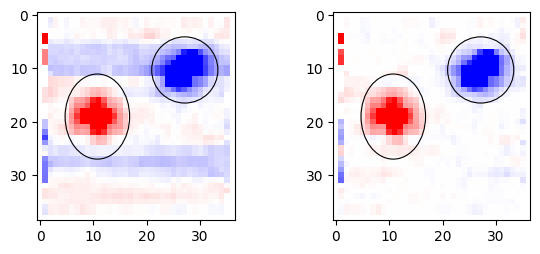

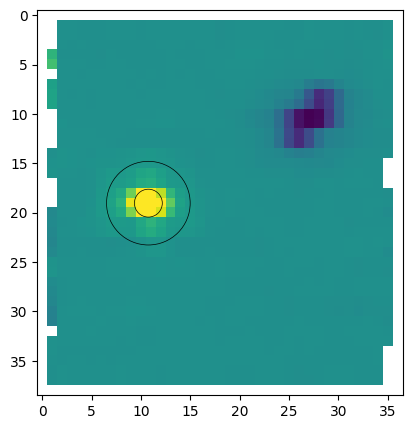

2025-03-05 11:30:13,804 - stpipe - WARNING - /net/schenk/data2/regt/JWST_reductions/jwst_nirspec_env/lib/python3.11/site-packages/stpsf/opds.py:1759: UserWarning: For (V2,V3) = [-8.39228333 -5.32616667] arcmin, Field point -8.254199999999999 arcmin, -2.473833333333334 arcmin not within valid region for field dependence model of OTE WFE for MIRI: -8.254199999999999 arcmin--6.21738 arcmin, -2.557224 arcmin--0.5632056 arcmin.  Clipping to closest available valid location, 0.13808333333333422 arcmin away from the requested coordinates.
  warnings.warn(warning_message)



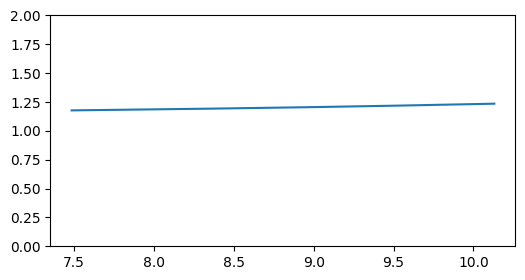

2025-03-05 11:30:42,426 - stpipe - WARNING - /net/schenk/data2/regt/JWST_reductions/jwst_nirspec_env/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,

2025-03-05 11:30:42,536 - stpipe - WARNING - /var/tmp/regt/ipykernel_2341621/1347671006.py:205: RuntimeWarning: All-NaN slice encountered
  collapse_horizontal = np.nanmedian(masked_cube, axis=2, keepdims=True)



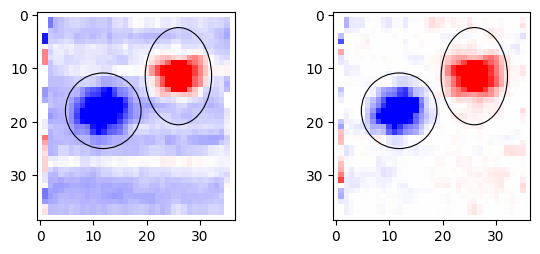

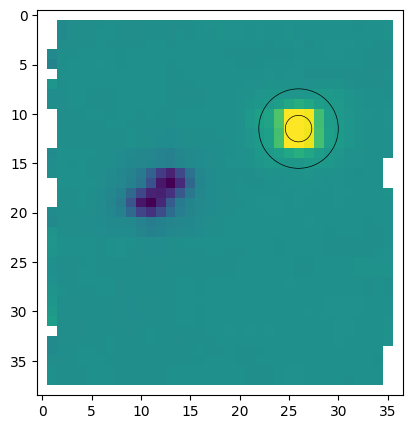

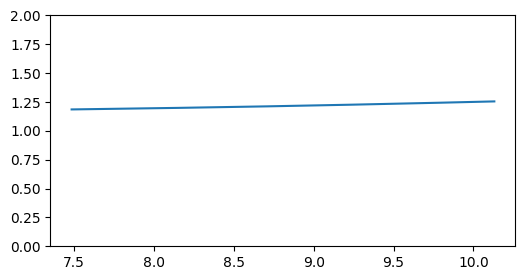

2025-03-05 11:30:44,568 - stpipe - WARNING - /net/schenk/data2/regt/JWST_reductions/jwst_nirspec_env/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,

2025-03-05 11:30:44,686 - stpipe - WARNING - /var/tmp/regt/ipykernel_2341621/1347671006.py:205: RuntimeWarning: All-NaN slice encountered
  collapse_horizontal = np.nanmedian(masked_cube, axis=2, keepdims=True)



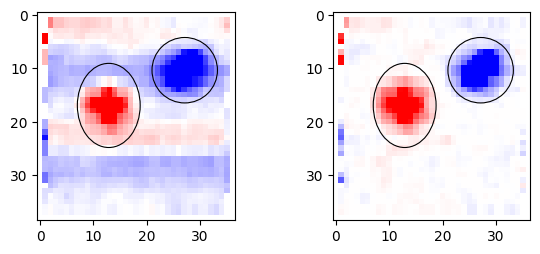

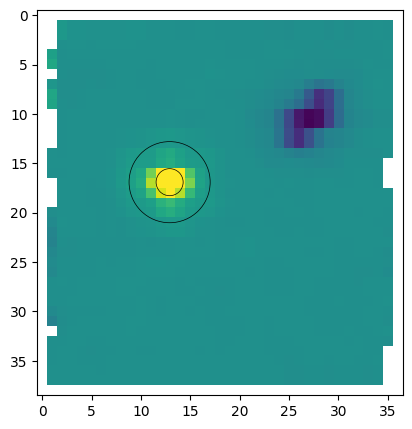

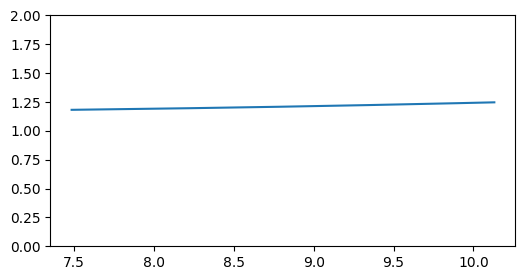

2025-03-05 11:30:46,713 - stpipe - WARNING - /net/schenk/data2/regt/JWST_reductions/jwst_nirspec_env/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,

2025-03-05 11:30:46,824 - stpipe - WARNING - /var/tmp/regt/ipykernel_2341621/1347671006.py:205: RuntimeWarning: All-NaN slice encountered
  collapse_horizontal = np.nanmedian(masked_cube, axis=2, keepdims=True)



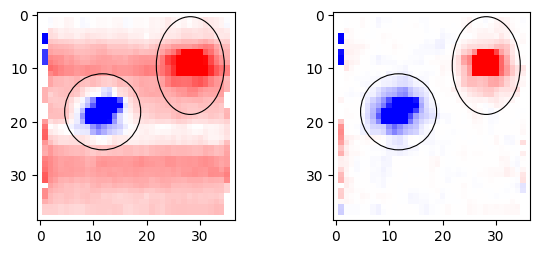

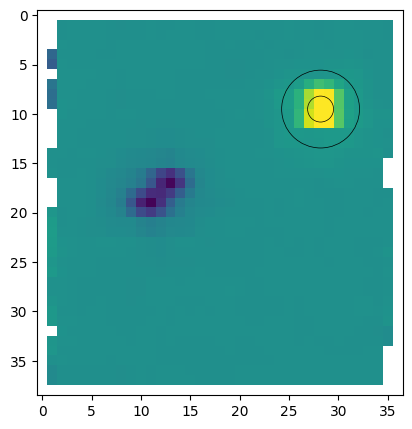

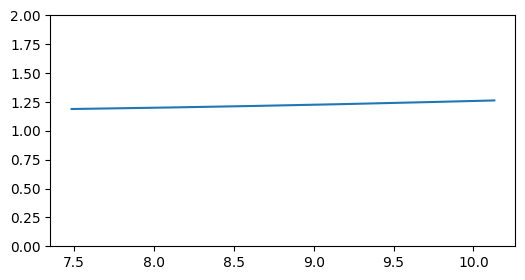

"\n# Combine the dithers\nwave_final, flux_final, flux_err_final = weighted_mean(\n    all_wave, all_flux, all_flux_err, sigma_clip=20, plot=True, #xlim=(7.8,8.2), \n    )\n# Convert to regular units\nflux_final, flux_err_final = convert_Jy_to_F_lam(wave_final, flux_final, flux_err_final)\n\n# Save the results\nnp.savetxt(\n    './Miles_ea_2023/reduction_05_03_2025/miri_{}{}.dat'.format(channel, subchannel_synonyms[subchannel]), \n    np.array([wave_final, flux_final, flux_err_final]).T, delimiter=',', \n    header='Wavelength (microns), Flux(W/m^2/microns), Flux Error(W/m^2/microns)', \n    )\n"

In [4]:
%matplotlib inline
#filename = './ifu_data_01386/MAST_2025-02-26T10_24_21.462Z/JWST/jw01386013001_{0}_{1:05d}/jw01386013001_{0}_{1:05d}_{2}_{3}.fits'
filename = './MIRI_ifu_data_01386/stage2/jw01386014001_{0}_{1:05d}_{2}_{3}.fits'
inf_coeff = 3

all_wave, all_flux, all_flux_err = [], [], []

channel = 2
subchannel = 'medium'
subchannel_synonyms = {'short': 'A', 'medium': 'B', 'long': 'C'}

if channel in [1,2]:
    detector = 'mirifushort'
elif channel in [3,4]:
    detector = 'mirifulong'
    
for dither in range(1,5):
    # xy_guess = [
    #     [(15,19), (25,16)], [(25,16), (15,19)], [(15,19), (25,16)], [(25,16), (15,19)]
    #     ][dither-1]
    xy_guess = None
    
    if subchannel == 'short':
        file_s3d = filename.format('03102', dither, detector, 's3d')
    elif subchannel == 'medium':
        file_s3d = filename.format('03104', dither, detector, 's3d')
    elif subchannel == 'long':
        file_s3d = filename.format('03106', dither, detector, 's3d')

    wave, cube, cube_err = load_data(file_s3d, file_x1d=file_s3d.replace('s3d', 'x1d'))

    # Split into 2 channels
    idx_split = cube.shape[0]//2
    if channel in [1,3]:
        wave, cube, cube_err = wave[:idx_split], cube[:idx_split], cube_err[:idx_split]
    elif channel in [2,4]:
        wave, cube, cube_err = wave[idx_split:], cube[idx_split:], cube_err[idx_split:]

    # Correct for the horizontal stripes
    cube_corrected, xy_guess = remove_horizontal_stripes(cube, plot=True, inf_coeff=[4.5,3.5], xy_guess=xy_guess)
    
    # Locate the point source
    g_fit = fit_gaussian_2d(cube_corrected, xy_guess, inf_coeff, plot=True)
    aper_kwargs = dict(
        positions=(g_fit.x_mean.value, g_fit.y_mean.value), theta=g_fit.theta.value, 
        a=g_fit.x_stddev.value*inf_coeff, b=g_fit.y_stddev.value*inf_coeff
        )
    flux, flux_err = extract_1d(wave, cube_corrected, cube_err, aper_kwargs, plot=False)

    #'''
    if dither == 1:
        # Only instantiate the ApertureCorrection object once
        A = ApertureCorrection(wave=wave, band=f'{channel}{subchannel_synonyms[subchannel]}')
    
    # Correct for the missing flux outside of the aperture 
    aperture_correction = A.get_correction_factor(aper_kwargs)
    flux     *= aperture_correction
    flux_err *= aperture_correction
    #'''

    # Correct for residual fringes
    flux = fit_residual_fringes_1d(flux, wave, channel=channel)

    all_wave.append(wave)
    all_flux.append(flux)
    all_flux_err.append(flux_err)

'''
# Combine the dithers
wave_final, flux_final, flux_err_final = weighted_mean(
    all_wave, all_flux, all_flux_err, sigma_clip=20, plot=True, #xlim=(7.8,8.2), 
    )
# Convert to regular units
flux_final, flux_err_final = convert_Jy_to_F_lam(wave_final, flux_final, flux_err_final)

# Save the results
np.savetxt(
    './Miles_ea_2023/reduction_05_03_2025/miri_{}{}.dat'.format(channel, subchannel_synonyms[subchannel]), 
    np.array([wave_final, flux_final, flux_err_final]).T, delimiter=',', 
    header='Wavelength (microns), Flux(W/m^2/microns), Flux Error(W/m^2/microns)', 
    )
'''

# NIRSPEC

### Extraction per dither (NIRSPEC)

2025-03-05 10:31:18,234 - stpipe - WARNING - /net/schenk/data2/regt/JWST_reductions/jwst_nirspec_env/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,

2025-03-05 10:31:18,422 - stpipe - WARNING - /var/tmp/regt/ipykernel_2306958/1347671006.py:205: RuntimeWarning: All-NaN slice encountered
  collapse_horizontal = np.nanmedian(masked_cube, axis=2, keepdims=True)



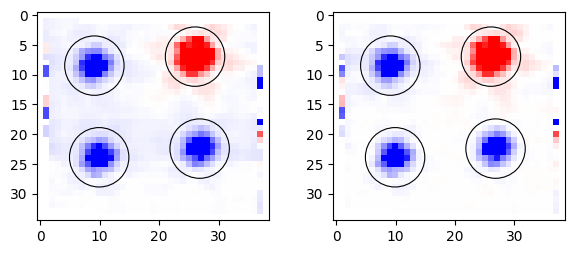

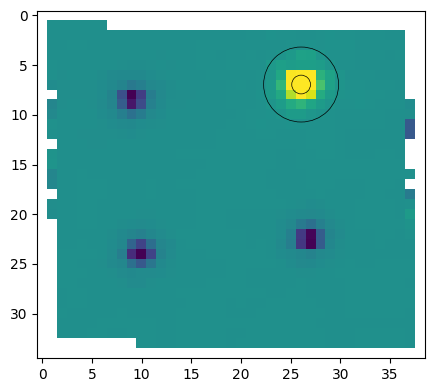

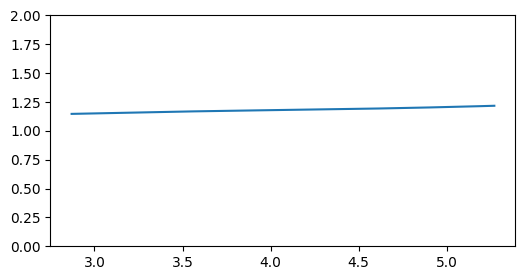

2025-03-05 10:32:28,948 - stpipe - WARNING - /net/schenk/data2/regt/JWST_reductions/jwst_nirspec_env/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,

2025-03-05 10:32:29,132 - stpipe - WARNING - /var/tmp/regt/ipykernel_2306958/1347671006.py:205: RuntimeWarning: All-NaN slice encountered
  collapse_horizontal = np.nanmedian(masked_cube, axis=2, keepdims=True)



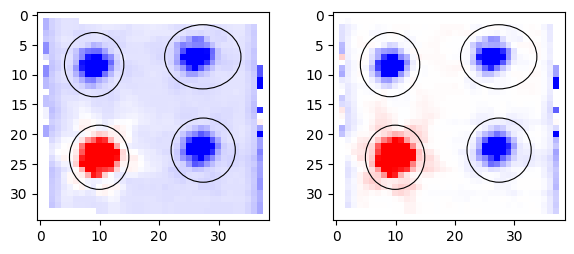

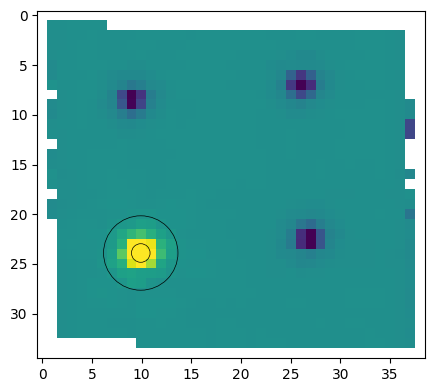

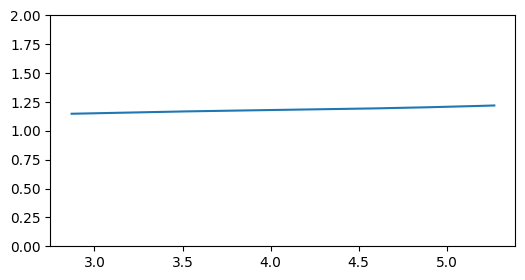

2025-03-05 10:32:31,357 - stpipe - WARNING - /net/schenk/data2/regt/JWST_reductions/jwst_nirspec_env/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,

2025-03-05 10:32:31,612 - stpipe - WARNING - /var/tmp/regt/ipykernel_2306958/1347671006.py:205: RuntimeWarning: All-NaN slice encountered
  collapse_horizontal = np.nanmedian(masked_cube, axis=2, keepdims=True)



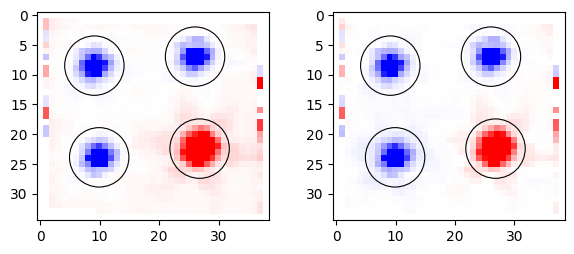

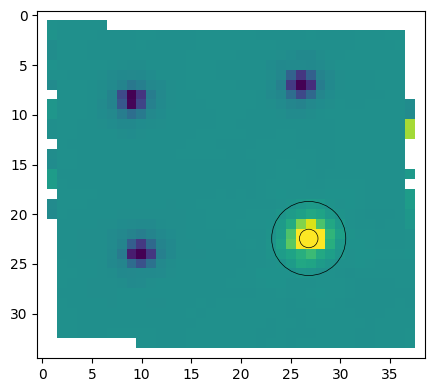

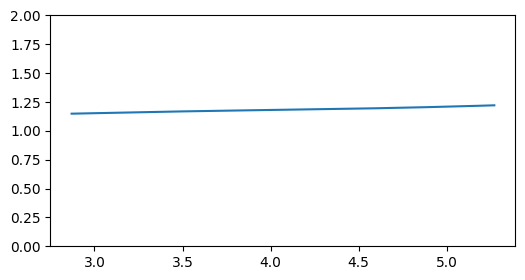

2025-03-05 10:32:33,642 - stpipe - WARNING - /net/schenk/data2/regt/JWST_reductions/jwst_nirspec_env/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,

2025-03-05 10:32:33,876 - stpipe - WARNING - /var/tmp/regt/ipykernel_2306958/1347671006.py:205: RuntimeWarning: All-NaN slice encountered
  collapse_horizontal = np.nanmedian(masked_cube, axis=2, keepdims=True)



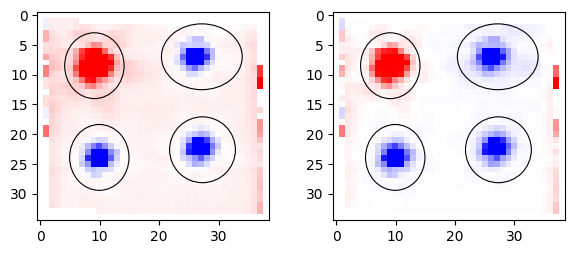

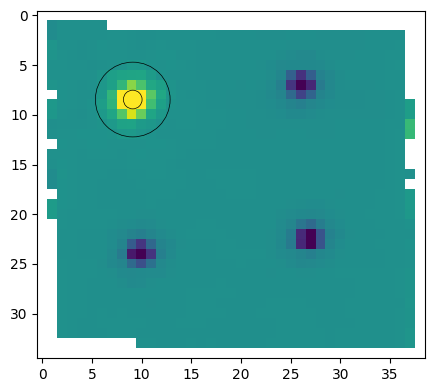

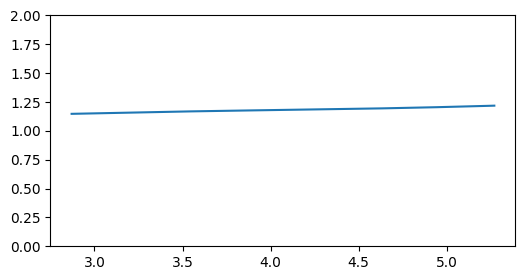

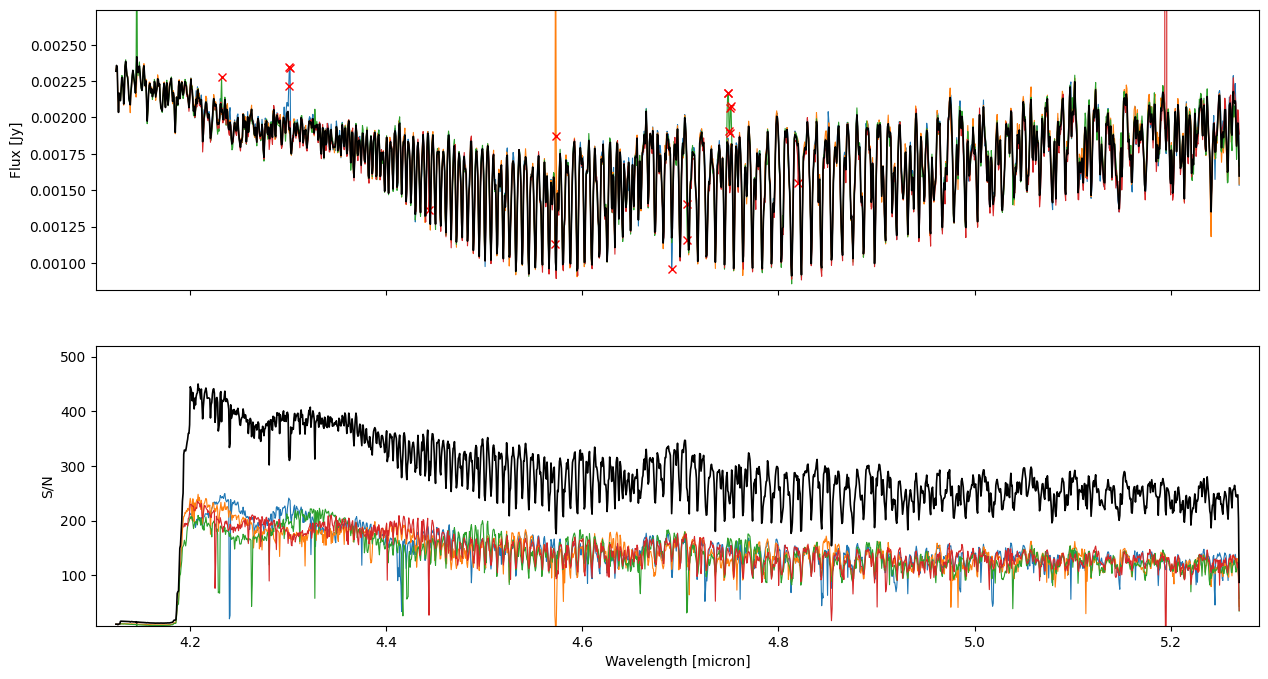

In [14]:
%matplotlib inline
#filename = './NIRSPEC_ifu_data_01386/MAST_2025-02-26T10_24_21.462Z/JWST/jw01386013001_{0}_{1:05d}/jw01386013001_{0}_{1:05d}_{2}_{3}.fits'
filename = './NIRSPEC_ifu_data_01386/stage2/jw01386013001_{0}_{1:05d}_{2}_{3}.fits'
xy_guess = [
    #(19, 33), (13, 18), (35, 26), (28, 11), 
    [(28, 7), (9, 8), (10, 24), (28, 23)], 
    [(10, 24), (28, 7), (9, 8), (28, 23)], 
    [(28, 23), (28, 7), (9, 8), (10, 24)], 
    [(9, 8), (28, 7), (10, 24), (28, 23)], 
]
inf_coeff = 4

all_wave, all_flux, all_flux_err = [], [], []

detector = 'nrs2'
#grating = 'g140h'
#grating = 'g235h'
grating = 'g395h'
filters = {'g235h': 'f170lp', 'g395h': 'f290lp', 'g140h': 'f100lp'}
for dither in range(1,5):

    if grating == 'g140h':
        file_s3d = filename.format('03106', dither, detector, 's3d')
        file_x1d = filename.format('03106', dither, detector, 'x1d')
        file_Miles = './Miles_ea_2023/detector{}_f100lp_g140h.txt'.format(detector[-1])
    elif grating == 'g235h':
        file_s3d = filename.format('03102', dither, detector, 's3d')
        file_x1d = filename.format('03102', dither, detector, 'x1d')
        file_Miles = './Miles_ea_2023/detector{}_f170lp_g235h.txt'.format(detector[-1])
    elif grating == 'g395h':
        file_s3d = filename.format('03104', dither, detector, 's3d')
        file_x1d = filename.format('03104', dither, detector, 'x1d')
        file_Miles = './Miles_ea_2023/detector{}_f290lp_g395h.txt'.format(detector[-1])

    wave, cube, cube_err = load_data(file_s3d=file_s3d, file_x1d=file_x1d)

    # Correct for the horizontal stripes
    cube_corrected, xy_guess_new = remove_horizontal_stripes(
        cube, plot=True, inf_coeff=[5]*4, xy_guess=xy_guess[dither-1]
        )
    
    # Locate the point source
    g_fit = fit_gaussian_2d(cube_corrected, xy_guess_new, inf_coeff, plot=True)
    aper_kwargs = dict(
        positions=(g_fit.x_mean.value, g_fit.y_mean.value), theta=g_fit.theta.value, 
        a=g_fit.x_stddev.value*inf_coeff, b=g_fit.y_stddev.value*inf_coeff
        )
    flux, flux_err = extract_1d(wave, cube_corrected, cube_err, aper_kwargs, plot=False)

    #'''
    if dither == 1:
        # Only instantiate the ApertureCorrection object once
        A = ApertureCorrection(wave=wave, disperser=grating.upper(), filter=filters[grating])
    
    # Correct for the missing flux outside of the aperture 
    aperture_correction = A.get_correction_factor(aper_kwargs)
    flux     *= aperture_correction
    flux_err *= aperture_correction
    #'''

    all_wave.append(wave)
    all_flux.append(flux)
    all_flux_err.append(flux_err)

# Combine the dithers
wave_final, flux_final, flux_err_final = weighted_mean(all_wave, all_flux, all_flux_err, sigma_clip=20, plot=True)#, xlim=(2.12,2.23))
# Convert to regular units
flux_final, flux_err_final = convert_Jy_to_F_lam(wave_final, flux_final, flux_err_final)

# Save the results
np.savetxt(
    './Miles_ea_2023/reduction_05_03_2025/nirspec_{}_{}.dat'.format(grating[1:], detector[-1]), 
    np.array([wave_final, flux_final, flux_err_final]).T, delimiter=',', 
    header='Wavelength (microns), Flux(W/m^2/microns), Flux Error(W/m^2/microns)', 
    )

### Extraction on combined dither-cube (NIRSPEC)

In [ ]:
#grating = 'g140h'; filter = 'f100lp'
grating = 'g235h'; filter = 'f170lp'
#grating = 'g395h'; filter = 'f290lp'

file_s3d = './ifu_data_01386/stage3/Level3_{}-{}_s3d.fits'.format(grating, filter)
inf_coeff = 4

# Load data
wave, cube, cube_err = load_data(file_s3d, file_x1d=file_s3d.replace('s3d', 'x1d'))

# Locate the PSF
xy_guess = (cube.shape[2]//2+1, cube.shape[1]//2+1)
g_fit = fit_gaussian_2d(cube, xy_guess, inf_coeff, plot=True)

# Perform the 1D extraction
aper_kwargs = dict(
    positions=(g_fit.x_mean.value, g_fit.y_mean.value), 
    theta=g_fit.theta.value, 
    a=g_fit.x_stddev.value*inf_coeff, 
    b=g_fit.y_stddev.value*inf_coeff
    )
flux, flux_err = extract_1d(wave, cube, cube_err, aper_kwargs, plot=True)

# Convert to regular units
flux, flux_err = convert_Jy_to_F_lam(wave, flux, flux_err)

# Save the results
np.savetxt(
    #'./Miles_ea_2023/reduction_26_02_2025/nirspec_{}.dat'.format(grating), np.array([wave, flux, flux_err]).T, 
    delimiter=',', header='Wavelength (microns), Flux(W/m^2/microns), Flux Error(W/m^2/microns)', 
    )

In [ ]:
# Load data from Miles et al. (2023)
file_Miles = './Miles_ea_2023/detector1_{}_{}.txt'.format(filter, grating)
wave_M1, flux_M1, flux_err_M1 = load_data_Miles_ea_2023(file_Miles)
wave_M2, flux_M2, flux_err_M2 = load_data_Miles_ea_2023(file_Miles.replace('detector1', 'detector2'))

wave_M = np.concatenate([wave_M1, wave_M2])
flux_M = np.concatenate([flux_M1, flux_M2])
flux_err_M = np.concatenate([flux_err_M1, flux_err_M2])

flux_M, flux_err_M = convert_Jy_to_F_lam(wave_M, flux_M, flux_err_M)

# Plot for comparison
xlim = (wave[np.isfinite(flux)][0]-0.02, wave[np.isfinite(flux)][-1]+0.02)
ylim = (np.nanpercentile(flux, 1)*1/1.2, np.nanpercentile(flux, 99)*1.2)

fig, ax = plt.subplots(figsize=(14,7), nrows=2, sharex=True)
ax[0].plot(wave_M, flux_M, lw=0.8, c='indianred', label='Miles et al. (2023)')
ax[0].plot(wave, flux, lw=1.2, c='k', label='New reduction')

ax[1].plot(wave_M, flux_M-np.interp(wave_M, wave, flux), lw=0.8, c='indianred', label='(Miles et al.) - (New reduction)')
ax[1].plot(wave_M, flux_M*0, lw=1.2, c='k')

ax[0].legend()
ax[1].legend()
ax[0].set(xlim=xlim, ylim=ylim, ylabel='Flux [W/m^2/micron]')
ax[0].set_xlim(2.18, 2.23)

ax[1].set(ylim=(-ylim[1]*0.2, ylim[1]*0.2), ylabel='Residual [W/m^2/micron]', xlabel='Wavelength [micron]')
plt.show()